<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init Segmentation

##Mount Google Drive, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True);

Mounted at /content/gdrive


### Installing and loading packages

In [3]:
#@markdown install debug packages
if False:
  !pip install -Uqq ipdb
  !pip install pympler
  !pip install psutil
  !pip install tracemalloc
  import ipdb


In [4]:
!pip show torch

Name: torch
Version: 2.0.1+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision, triton


In [5]:
%%capture
# !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
if False:
  !pip uninstall torch torchvision torchaudio
!pip install torch torchvision torchaudio --upgrade -f https://download.pytorch.org/whl/cu116
!pip install fastcore --upgrade
!pip install fastai --upgrade
!pip install imageio --upgrade
!pip install dill
!pip install json-tricks
!pip install ultraimport

### Import libraries

In [6]:
import pandas as pd
import torch
try:
  import torchvision
except:
  import importlib
  import PIL
  print("reloaded pil");
  importlib.reload(PIL);
  try:
    import torchvision
  except:
    exit();
from warnings import warn
import fastcore
import fastai
from fastai.vision.all import *
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity, adjust_gamma
from skimage.transform import resize
from typing import Callable,Dict,List,Tuple,Union
from tqdm import tqdm
import os
import numpy as np
from pathlib import Path
import re
import ntpath
import shutil
import stat
import dill
import json_tricks
import ultraimport
filenames = ultraimport('/content/gdrive/Othercomputers/UNC Laptop/libraries/filenames.py')


## Segmentation Parameters


### Basic Parameters
other shared settings between training and separation

In [7]:
#@markdown ### To specify a file in a bucket, prexis the path with gs://
#@markdown Whether input paths exist in a gcp bucket (will be autodetected if unset)
activate_gcp = False #@param {type:"boolean"}

def is_gcp_path(path:Path):
  return path.parts[0].lower() == "gs:";

#@markdown What object type you are segmenting
segmentation_target = "Cell" #@param ["Nucleus", "Cell", "Combined"]

#@markdown folder where processed images will be stored for training or segmentation
local_folder='local' #@param {type:"string"}
local_folder=Path(local_folder);

#@markdown folder where image processing metadata is stored
meta_folder = 'meta' #@param {type:"string"}
meta_folder = Path(meta_folder)

#@markdown folder where downloaded images will be stored temporarily for processing
temp_folder='temp' #@param {type:"string"}
temp_folder = Path(temp_folder);

#@markdown directory where models are stored and will be exported to
_modelsfolder = 'gs://optotaxisbucket/models/fastai' #@param {type:"string"}
_modelsfolder = Path(_modelsfolder);
if is_gcp_path(_modelsfolder):
  activate_gcp = True;


training_images_folder = local_folder/"train_images"
training_masks_folder = local_folder/"train_masks"
segmentation_images_folder = local_folder/"segmentation_images"
segmentation_output_folder = local_folder/"segmentation_masks_out"
local_modelsfolder = local_folder/"models";


local_folders = [local_folder,
            training_images_folder,
            training_masks_folder,
            segmentation_images_folder,
            segmentation_output_folder,
            local_modelsfolder,
            temp_folder];

def on_rm_error( func, path, exc_info):
    # path contains the path of the file that couldn't be removed
    # let's just assume that it's read-only and unlink it.
    os.chmod( path, stat.S_IWRITE )

def cleardir(dir): #clears all files in dir without deleting dir
  print("dir cleared:",dir)
  for f in os.scandir(dir):
    if os.path.isdir(f): shutil.rmtree(f,onerror=on_rm_error); #just in case
    else: os.remove(f);


for dir in local_folders:
  if not os.path.exists(dir):
    os.makedirs(dir);
  else:
    cleardir(dir);


### Image Preparation Settings
shared settings between training and segmentation image/mask processing

In [8]:
#@markdown ##Adjacent Image Stacking
#@markdown Whether to use several "adjacent" images as input instead of one
image_stacking = False #@param {type:"boolean"}
num_stacked_images = 3 #@param {type:"integer"}

#@markdown ### Mask stacking
#@markdown Whether to also train (and output) a mask for each input image, or just use the center.
#@markdown "Narrow" means only the center mask will be used. This cuts off the end and the beginning of the movie, depending on the width of stacking.
#@markdown "Wide" means a mask will be segmented for every image. This means there will be multiple corresponding masks per image! When segmenting in this notebook, they will be labeled by offset number in the output directory.
mask_stacking_type = "Narrow" #@param ["Narrow", "Wide"]
mask_stacking = (mask_stacking_type == "Wide")


#@markdown Scale factor - factor by which height and width will be multiplied, final dimensions rounded to nearest integer. (Default is 1, which does nothing)
scale_factor = 1 #@param {type:"number"}

do_scaling = scale_factor == 1


#@markdown ##Image Splitting and stitching
#@markdown Whether to split trained images into smaller chunks
do_splitting = True #@param {type:"boolean"}

#@markdown Number of slices (columns/rows) to divide input images into; for the math, please see https://www.desmos.com/calculator/xrqev2vluo
x_slices = 5 #@param {type:"integer"}
y_slices =  5 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  42#@param {type:"integer"}
dy =  32#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

if not do_splitting:
  x_slices = 1;
  y_slices = 1;
  dx = 0;
  dy = 0;
  x_crop = 0;
  y_crop = 0;

context_bounds = [dy,dx]*2 #assuming x and y bounds are symmetrical to both sides of the image, which might not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x

### Training-Specific Settings
parameters and paths only for training

In [9]:
#@markdown ## Training Source
#@markdown location - zip file or folder - where input images are stored
_training_images="/content/gdrive/Othercomputers/UNC Laptop/iter3/round6/images" #@param {type:"string"}
_training_images=Path(_training_images);

#@markdown input folder where masks are stored (will not be edited)
_training_masks="/content/gdrive/Othercomputers/UNC Laptop/iter3/round6/train_in" #@param {type:"string"}
_training_masks=Path(_training_masks);

if (is_gcp_path(_training_images) or is_gcp_path(_training_masks)):
  activate_gcp = True;

#@markdown UNET model that will be used to train from, relative to modelsfolder. if left blank, a new model will be created (customizable in the cell in training.)
inmodelname = '' #@param {type:"string"}
#@markdown where the model will be exported to after training, in modelsfolder (if modelsfolder is gcp, will also update)
outmodelname = '' #@param {type:"string"}

#@markdown ## Training Data Augmentation

#@markdown ### Gamma (avg brightness) adjustments
do_gamma = False #@param {type:"boolean"}
gamma_aug_list = [0.5,0.8,1,1.2,1.5] #@param {type:"raw"}

#@markdown whether to have the model output at half resolution (only applies to newly created models)
model_halfres = False #@param {type:"boolean"}

#@markdown Mask Scale Factor - if input mask needs to be scaled by a different factor than input image, add it here. Multiplies with the overall factor. 1 keeps default behavior.
train_mask_scale_factor = 0.5 #@param {type:"number"}


### Segmentation-Specific Settings
parameters and paths only for segmenting an experiment


In [10]:
#@markdown Path of the folder containing the movies in GCP bucket
_segmentation_images="/content/gdrive/Othercomputers/UNC Laptop/iter3/round7/images"  #@param {type:"string"}
_segmentation_images=Path(_segmentation_images);

#@markdown name of the model used to segment
segment_model_name="iter1_10_continue.pkl" #@param {type:"string"}

#@markdown path of the folder where the output masks will be deposited. if in gcp bucket (prefix with gs://), will be exported
_segmentation_output_masks='/content/gdrive/Othercomputers/UNC Laptop/cellness_testing/round1/seg_out' #@param {type:"string"}
_segmentation_output_masks=Path(_segmentation_output_masks);

if is_gcp_path(_segmentation_images) or is_gcp_path(_segmentation_output_masks):
  activate_gcp = True;

#@markdown if the output of the segmentation needs to be scaled up/down by a certian factor, put it here.
segmentation_mask_scale_factor = 1 #@param {type:"number"}



### Activate GCP if necessary

In [11]:
if activate_gcp:
  from google.colab import auth
  #This allows SDK to see and edit Google Drive files
  #SDK is required to interact with GCP
  auth.authenticate_user()

## Shared helper functions

### File Transfer / Management

In [12]:

def _fetch_gcp_files(in_path:Path,keyword:str,overwrite:bool)->Path: ##should not be called outside of other helper functions
  is_file = str(in_path).lower().endswith(('.zip','.tif','.tiff'));
  destination = temp_folder/keyword/in_path.stem;
  if not(os.path.exists(destination)):
    os.makedirs(destination);
  # copy_out = Path(destination)/in_path.name;
  command_output = None;
  if (is_gcp_path(in_path)): #first part is gs:, must be removed to work with gcloud
    in_path = Path(*in_path.parts[1:])
  if overwrite or len(os.listdir(destination)) == 0:
    if is_file:
      command_output = !gsutil -m cp -r "gs://{in_path}" "{destination}"
    else:
      command_output = !gsutil -m rsync -r "gs://{in_path}" "{destination}"
  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while downloading {keyword} from bucket: " + '\n'.join(command_output));
  elif len(os.listdir(destination)) == 0:
    raise RuntimeError("Error: downloading failed for an unknown reason; Command Output:",command_output);
  if (not is_file):
    return destination; #we're done
  else:
    destination = destination/in_path.name;
  if (in_path.suffix == '.zip'):
    out_path = destination.with_suffix('');
    command_output = None;
    if (overwrite or not os.path.exists(out_path)):
      command_output = !unzip -o "{destination}" -d "{destination.parent}"
    if (command_output is not None and command_output[0].startswith("CommandException")):
      raise RuntimeError(f"Error while unzipping {keyword}: " + '\n'.join(command_output));
    elif not os.path.exists(out_path):
      raise RuntimeError(f"Error while unzipping (from GCP): zip file {destination.name} does not contain folder {destination.with_suffix('').name}");
    return out_path;
  elif (in_path.suffix.lower().startswith('.tif')):
    raise NotImplementedError("unstacking TIF files not yet supported");
  else:
    raise NameError("Invalid input suffix, input validation should have caught this >:(");

def _push_gcp_files(in_folder:Path,out_path:Path,keyword:str,overwrite:bool):
  print(in_folder,out_path)
#   breakpoint()
  assert os.path.isdir(in_folder);
  if (is_gcp_path(out_path)): #first part is gs:, must be removed to work with gcloud
    out_path = Path(*out_path.parts[1:])

  command_output = None;

  if (out_path.suffix != ''): #file
    in_file = None;
    if (out_path.suffix.lower() == '.zip'):
      command_output = !zip "{temp/keyword/zip/out_path.name}"  "{in_folder}"
      if (command_output is not None and command_output[0].startswith("CommandException")):
        raise RuntimeError(f"Error while zipping {keyword} folder {in_folder} to zip file: " + '\n'.join(command_output));
      in_file = temp_folder/keyword/zip/out_path.name;
    elif (out_path.suffix.lower().startswith('.tif')):
      raise NotImplementedError("stacking TIF files not yet supported");
    else:
      raise NameError("Invalid output suffix; can only zip or stack tiffs. If the output is a directory, please do not add a file suffix.")

    if overwrite:
      command_output = !gsutil -m cp -r "{in_file}" "gs://{out_path}"
    else:
      command_output = !gsutil -m cp -r -n "{in_file}" "gs://{out_path}"
  else: #upload entire directory
    command_output = !gsutil -m rsync -r "{in_folder}" "gs://{out_path}"

  if (command_output is not None and command_output[0].startswith("CommandException")):
    raise RuntimeError(f"Error while uploading {keyword} to bucket: " + '\n'.join(command_output));
  return


In [13]:
_keyword_map = {"models":(_modelsfolder,local_modelsfolder),
               "train_images":(_training_images,training_images_folder),
               "train_masks":(_training_masks,training_masks_folder),
               "segmentation_images":(_segmentation_images,segmentation_images_folder),
               "segmentation_masks":(_segmentation_output_masks,segmentation_output_folder)};

_keyword_sources:Dict[str,Union[None,Path]] = {name:None for name in _keyword_map};


In [14]:
def _fetch_sourcefolder(keyword,overwrite=True)->Path:
  """returns the folder with the raw files, after unzip and or download if necessary."""
  if (not overwrite and _keyword_sources[keyword] is not None):
    return _keyword_sources[keyword];
  source = _keyword_map[keyword][0];
  result = source;
  if (is_gcp_path(source)):
    result = _fetch_gcp_files(source,keyword,overwrite=True);
  elif (source.suffix == '.zip'):
    destination = temp_folder/keyword;
    os.mkdir(destination);
    command_output = !unzip -o "{source}" -d "{destination}"
    result = destination/source.stem;
    if (not os.path.exists(result)):
      raise RuntimeError(f"Error while unzipping: zip file {source} does not contain folder {source.stem}");
  if (_keyword_sources[keyword] is not None and _keyword_sources[keyword] != result):
    raise RuntimeError(f"Error fetching sourcefolder for keyword {keyword}: sourcefolder already exists in a different location - are you pushing before you fetch?");
  _keyword_sources[keyword] = result;
  return result;

def _push_sourcefolder(keyword,overwrite=True):
  """inverse of fetch_sourcefolder - zips sourcefolder to original location or pushes to gcp if appropriate, otherwise noop"""
  sourcefolder = _keyword_sources[keyword];
  if (sourcefolder is None):
    raise RuntimeError("")
  dest = _keyword_map[keyword][0];
  if (is_gcp_path(dest)):
    _push_gcp_files(sourcefolder,dest,keyword,overwrite=overwrite);
  elif (dest.suffix == '.zip'):
    raise NotImplementedError("local sourcefolder zipping not implemented");
  pass;



from dataclasses import dataclass,astuple
@dataclass
class Img:
    name:str
    img:np.ndarray
    metadata:dict[str,Any]

    def copy(self):
        return Img(*self)

    def __iter__(self):
        return iter(astuple(self))

    # def __repr__

    def __str__(self):
        return f"Image {self.name} of shape {self.img.shape} and metadata {list(self.metadata.keys())}"

_single_proc = Callable[[Img],Union[Img,Iterable[Img]]]
# _multi_proc =
proc_type = Callable[[Union[Img,Iterable[Img]]],Union[Img,Iterable[Img]]]

from functools import wraps
def doublewrap(f):
    '''
    a decorator decorator, allowing the decorator to be used as:
    @decorator(with, arguments, and=kwargs)
    or
    @decorator
    '''
    @wraps(f)
    def new_dec(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            # actual decorated function
            return f(args[0])
        else:
            # decorator arguments
            return lambda realf: f(realf, *args, **kwargs)

    return new_dec

from typing import DefaultDict,Dict,TypeVar
K = TypeVar('K')
V = TypeVar('V')
def merge_data(*dicts:Dict[K,V],require_all_present=True,require_all_equal=True)->Dict[K,V]:
    if not require_all_present:
        if not require_all_equal:
            dd = DefaultDict(list)
            for d in dicts: # you can list as many input dicts as you want here
                for key, value in d.items():
                    dd[key].append(value)
            return {k:v[0] for k,v in dd.items()}
        else:
            dd = {}
            null = object()
            for d in dicts:
                for key,value in d.items():
                    if key in dd:
                        if dd[key] is not null and dd[key] != value:
                            dd[key] = null
                    else:
                        dd[key] = value
            return {k:v for k,v in dd.items() if v is not null}

    else:
        if not require_all_equal:
            dd = {k:[] for k in dicts[0].keys()}
            for d in dicts:
                bad = []
                for key in dd.keys():
                    if key not in d:
                        bad.append(key)
                    else:
                        dd[key].append(d[key])
                [dd.pop(k) for k in bad]
            return {k:v[0] for k,v in dd.items()}
        else:
            dd = dicts[0].copy()
            for d in dicts:
                bad = []
                for key in dd.keys():
                    if key not in d:
                        bad.append(key)
                    else:
                        if dd[key] != d[key]:
                            bad.append(key)
                # print(bad)
                [dd.pop(k) for k in bad]
            return dd


#for both processing and deprocessing images
#this allows functions like splitting or stitching of images; splititng returns multiple images, stitching can return [] for all images concatenated into a larger one
@doublewrap
def proc_fn(fn:Union[_single_proc,proc_type],*,multi=False)->proc_type:
    if multi:
        assert isinstance(fn,proc_type)
    def new_proc(im:Union[Img,Iterable[Img]]):
        # print(im)
        if isinstance(im,Img) or multi:
            res = fn(im)
        else:
            r = [fn(i) for i in im]
            r = [[k] if isinstance(k,Img) else k for k in r]
            res = [x for l in r for x in l]
        # print(f"Result of applying function {fn}: {res}")
        return res
    return new_proc

def _decopy_local(keyword:str,push_source=True):
  dest = _keyword_sources[keyword] or temp_folder/keyword/_keyword_map[keyword][0].stem;
  _keyword_sources[keyword] = dest;
  local = _keyword_map[keyword][1];

  print(f"{local}->{dest}")
  command_out = !gsutil -m rsync "{local}" "{dest}"
  if (command_out[0].startswith("CommandException")):
    raise Exception("error copying",keyword,"files:",command_out);

  if push_source:
    _push_sourcefolder(keyword);

def _deprocess_images(keyword:str,deprocess_fn:proc_type,push_source=True,do_warn=True):
  dest = _keyword_sources[keyword]
  if dest is None:
    p_source = _keyword_map[keyword][0]; #p for prospective
    print("checking prospective source",p_source);
    if (is_gcp_path(p_source) or p_source.is_file()):
      print("file/gcp found: requires temp folder")
      dest = temp_folder/keyword/_keyword_map[keyword][0].stem;
      _keyword_sources[keyword] = dest;
      if not os.path.exists(dest):
        os.makedirs(dest);
    else:
      print("not file nor gcp: writing directly to source");
      _keyword_sources[keyword] = p_source;
      dest = p_source

  if not os.path.exists(dest):
    os.makedirs(dest)

  local = _keyword_map[keyword][1];

  for im in tqdm(os.listdir(local)):
    path = local/im;
    if (path.suffix not in (".tif",".tiff",".TIF",".TIFF")):
        if do_warn:
            warn(f"non-image file in {keyword} dir: {im}");
        continue;
    try:
      image = imread(path);
    except:
      raise RuntimeError("unable to read image",path);
    try:
        data = json_tricks.load(str(meta_folder/keyword/im))
    except:
        if keyword == "segmentation_masks":
            data = json_tricks.load(str(meta_folder/"segmentation_images"/im))
            data["keyword"] = keyword
            data["sourcefolder"] = dest
        else:
            warn(f"Unable to read image processing metadata for image {im}")
            data = {"keyword":keyword,"sourcefolder":dest}
    processed = deprocess_fn(Img(im,image,data));
    # print(deprocess_fn)
    if isinstance(processed,Img):
      processed = [processed];
    print(f"deprocessed: {processed}")
    for name,p,data_dict in processed:
      imsave(dest/name,p,check_contrast=False);

  if push_source:
    _push_sourcefolder(keyword);

def _copy_local(keyword:str,overwrite_source=False):
  source = _fetch_sourcefolder(keyword,overwrite=overwrite_source);
  dest = _keyword_map[keyword][1];

  command_out = !gsutil -m rsync "{source}" "{dest}"
  if (command_out[0].startswith("CommandException")):
    raise Exception("error copying",keyword,"files:",command_out);
  return dest;

def _process_images(keyword:str,process_fn:proc_type,overwrite_source=False,do_warn=True):
  source = _fetch_sourcefolder(keyword,overwrite=overwrite_source);
  dest =_keyword_map[keyword][1];
  if any(os.scandir(dest)):
    cleardir(dest);

  for im in tqdm(os.listdir(source)):
    path = source/im;
    if (path.suffix not in (".tif",".tiff",".TIF",".TIFF")):
        warn(f"non-image file in {keyword} dir: {im}");
        continue;
    image = imread(path);
    data_dict = {"sourcefolder":source,"keyword":keyword,"history":[]}
    processed = process_fn(Img(im,image,data_dict));
    if (isinstance(processed,Img)):
      processed = [processed];
    os.makedirs(meta_folder/keyword,exist_ok=True)
    for name,p,data in processed:
      imsave(dest/name,p,check_contrast=False);
      json_tricks.dump(data,str(meta_folder/keyword/name))

  return dest;


@proc_fn
def no_op(i):
    return i

def process_train_images(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("train_images",process_fn,overwrite_source=overwrite_source);

def process_segmentation_images(process_fn:proc_type=no_op,overwrite_source=False):
  return _process_images("segmentation_images",process_fn,overwrite_source=overwrite_source);

def process_train_masks(process_fn:proc_type=no_op,overwrite_source=False):
    # breakpoint()
    return _process_images("train_masks",process_fn,overwrite_source=overwrite_source);

def deprocess_segmentation_masks(process_fn:proc_type=no_op):
  _deprocess_images("segmentation_masks",process_fn,push_source=True);

def fetch_modelsfolder(overwrite=False):
  return _copy_local("models",overwrite_source=overwrite);

def push_modelsfolder(fetch=False):
  if (fetch):
    fetch_modelsfolder(overwrite=False);
  return _decopy_local("models",push_source=True);

def push_segmentation_folder():
  return _push_sourcefolder("segmentation_masks")

def _proc_wrap(func:proc_type):
  def wrapped(im:Union[Img,Iterable[Img]]):
    o = func(im);
    if (isinstance(o,Img)):
      o = [o];
    return o;
  return wrapped;

def _proc_compose(f1:proc_type,f2:proc_type)->proc_type:
  wf1 = _proc_wrap(f1);
  wf2 = _proc_wrap(f2);
  def composed(im:Union[Img,Iterable[Img]]):
    return [k for l in [wf2(i) for i in wf1(im)] for k in l]
  return composed;

def compose_proc_functions(funcs:List[proc_type]):
  return functools.reduce(_proc_compose,funcs);


def print_res(fn,name):
    def f(*args,**kwargs):
        r = fn(*args,**kwargs)
        print(f"{name}: {r}")
        return r
    return f


### Enumerator

In [15]:
from typing import DefaultDict, cast
# nameless_proc_type = Union[Callable[[Tuple[np.ndarray,dict]],Union[Tuple[np.ndarray,dict],List[Tuple[np.ndarray,dict]]]],Callable[[List[Tuple[np.ndarray,dict]]],Union[Tuple[np.ndarray,dict],List[Tuple[np.ndarray,dict]]]]]
class Enumerator: #simple in-out mapper for splitting/stitching like operations
    @classmethod
    def create(cls,process_fn:proc_type,enum_in:bool=False,multi=False)->proc_type:
        """creates an Enumerator class to process named images with a simple numbering scheme; returns processing function to give to process/deprocess images
        args:
        - process_fn: function that processes image (or ordered set of output images from another enumerator) and returns an image or list of images to be enumerated
        - enum_in (optional): whether process_fn inputs a single image or an enumerated list
        """
        enum = cls(process_fn,enum_in);
        return proc_fn(enum.process)

    def __init__(self,proc_fn:proc_type,enum_in:bool,delimiter:str='-',enumeration_name="enumeration"):
        self.name = enumeration_name
        self.proc = proc_fn;
        self.m_in = enum_in;
        self.delim = delimiter;
        self.queue:Dict[str,Union[Dict[int,Img],List[Union[Img,None]]]] = DefaultDict(dict);

    def process(self,im):
        assert isinstance(im,Img)
        name,ext = os.path.splitext(im.name);
        if (self.m_in):
            #accumulate images until we get a full set, then process them as a batch and release the result

            spl = name.rindex(self.delim)
            base = name[:spl];
            num = name[spl+len(self.delim):];
            final_im = num.endswith('f')
            num = int(num.rstrip("f"))


            if isinstance(self.queue[base],dict):
                #Check for metadata or final image to tell us how large this batch is
                if "enumeration" in im.metadata and self.name in im.metadata["enumeration"]:
                    #if metadata, use that and we're done
                    total:int = im.metadata["enumeration"][self.name]["total"]
                    assert num == im.metadata["enumeration"][self.name]["index"],f"{num} != {im.metadata['enumeration'][self.name]['index']}"
                    assert base == im.metadata["enumeration"][self.name]["basename"]
                    t:List[Img|None] = [None]*total
                    self.queue[base] = t
                elif final_im:
                    #otherwise, keep waiting for the final image
                    listed:List[Union[Img,None]] = [None for _ in range(num+1)];
                    q = self.queue[base]
                    assert isinstance(q,dict)
                    for n,im in q.items():
                        listed[n] = im;
                    self.queue[base] = listed

            self.queue[base][num] = im;
            im = im.copy()

            flush = self.flush_queue()

            ##yield all images from a generator of generators
            res = (k for x in (self._format_out(self.proc(t),n,ext) for n,t in flush) for k in x)
            return res
        else:
            #process image(s) in, enumerating the result and releasing as a batch
            if "enumeration" not in im.metadata:
                im.metadata["enumeration"] = OrderedDict()
            im.metadata["enumeration"][self.name] = {}

            return self._format_out(self.proc(im),im.name,ext)

    def _format_out(self,out:Union[Img,Iterable[Img]],name:str,ext:str):
        # print(f"formatting out:",out,"with name:",name)

        if (not isinstance(out,Img)):
            out = list(out)
            for i,im in enumerate(out):
                im.metadata["enumeration"][self.name]["index"] = i
                im.metadata["enumeration"][self.name]["total"] = len(out) #to ensure it can't be mistaken for an imagename; "/" is never allowed in a filename on any system
                im.metadata["enumeration"][self.name]["basename"] = name
                yield Img(f"{name}{self.delim}{i}" + ("f" if i == len(out)-1 else "") + ext,im.img,im.metadata)
        else:
            yield from [Img(name,out.img,out.metadata)];

    def flush_queue(self):
        complete = [];
        for name,tiles in self.queue.items():
            if isinstance(tiles,list) and all([t is not None for t in tiles]): #final found, all tiles full
                tiles = cast(List[Img],tiles)
                complete.append(name);
                # print("image complete:",name,tiles)
                yield (name,tiles);
        # print("complete:",complete)
        for n in complete:
            del self.queue[n];


### Image/Mask Processing

#### Preparation

In [16]:
@proc_fn
def prepare_image(im:Img):
    name,image,data = im
    image = rescale_intensity(image);
    if (image.dtype != "uint8"):
        image = (image/256).astype('uint8');
    if (len(image.shape) != 3 or image.shape[2] != 3):
        image = np.stack((image,image,image),axis=2);
    return Img(name,image,data)

@proc_fn
def prepare_mask(im:Img):
    name,mask,data = im
    #TODO: update for combined masks
    if (len(mask.shape) == 3):
        mask = mask[:,:,0];
    mask[mask>0] = 1;
    mask[mask<=0] = 0;
    mask = mask.astype('uint8');
    return Img(name,mask,data)


#### Splitting / Stitching

In [17]:
def create_split_image_process_fn(x_slices,y_slices,context_bounds,crop)->proc_type:
    @proc_fn
    def split_image(obj:Img):
        name,im,data = obj
        M = (im.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
        N = (im.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;

        if int(M) != M or int(N) != N:
            raise Exception(f"ERROR: Image with size {im.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
        else:
            M = int(M)
            N = int(N)
            tiles = [Img(name,im[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]],deepcopy(data))
                    for y in range(context_bounds[0]+crop[0],im.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M)
                    for x in range(context_bounds[1]+crop[1],im.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
            return tiles
    return Enumerator.create(split_image)

def create_stitch_image_process_fn(x_slices,y_slices,context_bounds,crop)->proc_type:
    def stitch_image(tiles:Iterable[Img]):
        stitchMasks = []
        assert not isinstance(tiles,Img)
        for i,(_,m,_) in enumerate(tiles):
            if isinstance(m,Tensor):
                m = m.numpy().astype('uint8')
            y = i // x_slices;
            x = i % x_slices;
            imBounds = [crop[0]+context_bounds[0] if y != 0 else 0,m.shape[0]-crop[2]-context_bounds[2] if y != y_slices-1 else m.shape[0],crop[1]+context_bounds[1] if x != 0 else 0 ,m.shape[1]-crop[3]-context_bounds[3] if x != x_slices - 1 else m.shape[1]];
            stitchMasks.append(m[imBounds[0]:imBounds[1],imBounds[2]:imBounds[3]]);
        stitched = np.concatenate([np.concatenate(stitchMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
        return Img("",stitched,merge_data(*(t.metadata for t in tiles)))
    return Enumerator.create(stitch_image,enum_in=True);

#### Stacking

In [18]:
import re,functools
regex = re.compile(r'(p[0-9]*)_s([0-9]+)_t([0-9]+).*(\.TIF|\.TIFF|\.tif|\.tiff)')
format = filenames.filename_format
default_regex = filenames.filename_regex_anybasename

def create_stack_adjacents(regex:str=default_regex):
    @proc_fn
    def stack_adjacents(image:Img): #should come before image preparation
        keyword = image.metadata["keyword"]
        if num_stacked_images != 3:
            if num_stacked_images == 1:
                raise Exception("Image stacking turned on, but only one image stack specified. Please just disable image stacking.")
            else:
                raise NotImplementedError("Because of fastai's UNET shape, only triple stacking (or no stacking) is supported at the moment. This is fixable if the model is edited, which is not implemented yet")
        m = re.match(regex,image.name);
        if not m:
            raise Exception("Improper regex / image name format")
        base,movie,frame,ext = m.groups()
        frame = int(frame)
        num_lower = int((num_stacked_images-1)/2)
        num_upper = num_stacked_images - num_lower - 1

        source = image.metadata["sourcefolder"]
        offsets = range(-num_lower,num_upper+1)
        assert 0 in offsets

        names = []
        final = []
        for off in offsets:
            if off == 0:
                im = image.img
            else:
                n = format.format(base,movie,frame+off,ext)
                if not os.path.exists(source/n):
                    tqdm.write(f"Skipping image {image.name} which is missing an image adjacency {n}.")
                    return []
                names.append(n)
                im = imread(source/n)
            final.append(im)
        f = np.stack(final,axis=2)
        meta = image.metadata.copy()
        meta["adjacency_names"] = names
        return Img(image.name,f,meta)
    return stack_adjacents

def unstack_adjacents(im:Img):
    raise Exception("adjacent image unstacking not implemented yet")



### Misc Processing Functions


In [19]:
def create_scale_image_process_fn(scale_factor:float)->proc_type:
    from skimage.util import img_as_bool
    @proc_fn
    def scale_image(im:Img):
        new_shape = [int(scale_factor*t) for t in im.img.shape[:2]] + [*im.img.shape[2:]]
        r = resize(im.img,new_shape,preserve_range=True).astype(im.img.dtype)
        # r = np.rint(),out=np.zeros(new_shape,im.img.dtype),casting='unsafe')
        return Img(im.name,r,deepcopy(im.metadata));
    return scale_image;

In [20]:
def create_gamma_image_process_fn(gammas:List[float])->proc_type:
    @proc_fn
    def gammafy_image(obj:Img):
        # image,data = obj
        return [Img(obj.name,adjust_gamma(obj.img,gamma),deepcopy(obj.metadata)) for gamma in gammas];
    return gammafy_image;


In [21]:
def create_duplicate_process_fn(num_duplicates:int)->proc_type:
    @proc_fn
    def duplicate_image(obj:Img):
        return [obj.copy() for _ in range(num_duplicates)]
    return duplicate_image

# Preparing data for trainining

### Prepare images and masks for training (see Image Preparation Settings)

In [ ]:
comp_fns = [];


## general comp functions
if do_splitting:
  comp_fns.append(create_split_image_process_fn(x_slices,y_slices,context_bounds,crop));

im_comp_fns:list[proc_type] = [prepare_image,*comp_fns];
mask_comp_fns:list[proc_type] = [prepare_mask,*comp_fns];


##mask/image specific comp functions
if do_scaling:
  im_comp_fns.append(create_scale_image_process_fn(scale_factor))

if scale_factor*train_mask_scale_factor != 1:
  mask_comp_fns.append(create_scale_image_process_fn(scale_factor*train_mask_scale_factor))

if do_gamma:
  im_comp_fns.append(create_gamma_image_process_fn(gamma_aug_list))
  mask_comp_fns.append(create_duplicate_process_fn(len(gamma_aug_list)))

if image_stacking:
    im_comp_fns.insert(0,create_stack_adjacents())
    if mask_stacking:
        mask_comp_fns.insert(0,create_stack_adjacents())

im_proc_fn = compose_proc_functions(im_comp_fns)
mask_proc_fn = compose_proc_functions(mask_comp_fns)


process_train_masks(mask_proc_fn)
process_train_images(im_proc_fn);

  8%|▊         | 7/90 [00:14<02:25,  1.75s/it]

Skipping image migration45_s5_t483.TIF which is missing an image adjacency migration45_s5_t482.TIF.


 10%|█         | 9/90 [00:16<01:58,  1.46s/it]

Skipping image migration45_s7_t354.TIF which is missing an image adjacency migration45_s7_t353.TIF.


 11%|█         | 10/90 [00:17<01:33,  1.17s/it]

Skipping image migration46_s4_t344.TIF which is missing an image adjacency migration46_s4_t343.TIF.


 14%|█▍        | 13/90 [00:22<01:43,  1.35s/it]

Skipping image migration47_s2_t199.TIF which is missing an image adjacency migration47_s2_t198.TIF.


 17%|█▋        | 15/90 [00:24<01:31,  1.23s/it]

Skipping image migration47_s4_t149.TIF which is missing an image adjacency migration47_s4_t148.TIF.


 18%|█▊        | 16/90 [00:25<01:15,  1.02s/it]

Skipping image migration45_s5_t376.TIF which is missing an image adjacency migration45_s5_t375.TIF.


 22%|██▏       | 20/90 [00:33<01:47,  1.54s/it]

Skipping image migration46_s4_t359.TIF which is missing an image adjacency migration46_s4_t358.TIF.


 23%|██▎       | 21/90 [00:34<01:24,  1.23s/it]

Skipping image migration46_s5_t105.TIF which is missing an image adjacency migration46_s5_t104.TIF.


 24%|██▍       | 22/90 [00:34<01:07,  1.01it/s]

Skipping image migration46_s8_t533.TIF which is missing an image adjacency migration46_s8_t532.TIF.


 26%|██▌       | 23/90 [00:35<00:56,  1.18it/s]

Skipping image migration47_s7_t122.TIF which is missing an image adjacency migration47_s7_t121.TIF.


 27%|██▋       | 24/90 [00:35<00:52,  1.27it/s]

Skipping image migration47_s4_t205.TIF which is missing an image adjacency migration47_s4_t204.TIF.


 28%|██▊       | 25/90 [00:36<00:45,  1.44it/s]

Skipping image migration50_s1_t104.TIF which is missing an image adjacency migration50_s1_t103.TIF.


 29%|██▉       | 26/90 [00:37<00:42,  1.49it/s]

Skipping image migration50_s2_t268.TIF which is missing an image adjacency migration50_s2_t267.TIF.


 30%|███       | 27/90 [00:37<00:38,  1.62it/s]

Skipping image migration50_s10_t210.TIF which is missing an image adjacency migration50_s10_t209.TIF.


 31%|███       | 28/90 [00:38<00:36,  1.68it/s]

Skipping image migration50_s1_t234.TIF which is missing an image adjacency migration50_s1_t233.TIF.


 32%|███▏      | 29/90 [00:38<00:34,  1.79it/s]

Skipping image migration50_s11_t167.TIF which is missing an image adjacency migration50_s11_t166.TIF.


 33%|███▎      | 30/90 [00:39<00:33,  1.81it/s]

Skipping image migration51_s2_t187.TIF which is missing an image adjacency migration51_s2_t186.TIF.


 34%|███▍      | 31/90 [00:39<00:32,  1.81it/s]

Skipping image migration51_s3_t265.TIF which is missing an image adjacency migration51_s3_t264.TIF.


 36%|███▌      | 32/90 [00:40<00:31,  1.84it/s]

Skipping image migration51_s8_t488.TIF which is missing an image adjacency migration51_s8_t487.TIF.


 37%|███▋      | 33/90 [00:40<00:31,  1.79it/s]

Skipping image migration51_s5_t493.TIF which is missing an image adjacency migration51_s5_t492.TIF.


 38%|███▊      | 34/90 [00:41<00:27,  2.02it/s]

Skipping image migration51_s11_t352.TIF which is missing an image adjacency migration51_s11_t351.TIF.


 39%|███▉      | 35/90 [00:41<00:26,  2.05it/s]

Skipping image migration53_s3_t276.TIF which is missing an image adjacency migration53_s3_t275.TIF.


 40%|████      | 36/90 [00:42<00:27,  2.00it/s]

Skipping image migration53_s1_t127.TIF which is missing an image adjacency migration53_s1_t126.TIF.


 41%|████      | 37/90 [00:42<00:26,  1.98it/s]

Skipping image migration53_s2_t140.TIF which is missing an image adjacency migration53_s2_t139.TIF.


 42%|████▏     | 38/90 [00:43<00:25,  2.00it/s]

Skipping image migration53_s8_t101.TIF which is missing an image adjacency migration53_s8_t100.TIF.


 43%|████▎     | 39/90 [00:43<00:24,  2.04it/s]

Skipping image migration54_s5_t121.TIF which is missing an image adjacency migration54_s5_t120.TIF.


 44%|████▍     | 40/90 [00:44<00:25,  1.98it/s]

Skipping image migration54_s12_t59.TIF which is missing an image adjacency migration54_s12_t58.TIF.


 46%|████▌     | 41/90 [00:44<00:24,  1.98it/s]

Skipping image migration54_s7_t270.TIF which is missing an image adjacency migration54_s7_t269.TIF.


 47%|████▋     | 42/90 [00:45<00:24,  1.94it/s]

Skipping image migration54_s10_t273.TIF which is missing an image adjacency migration54_s10_t272.TIF.


 48%|████▊     | 43/90 [00:45<00:25,  1.81it/s]

Skipping image migration54_s4_t160.TIF which is missing an image adjacency migration54_s4_t159.TIF.


 49%|████▉     | 44/90 [00:46<00:24,  1.84it/s]

Skipping image migration55_s3_t243.TIF which is missing an image adjacency migration55_s3_t242.TIF.


 53%|█████▎    | 48/90 [00:53<00:54,  1.31s/it]

Skipping image migration55_s6_t217.TIF which is missing an image adjacency migration55_s6_t216.TIF.


 56%|█████▌    | 50/90 [00:56<00:51,  1.28s/it]

Skipping image migration56_s1_t129.TIF which is missing an image adjacency migration56_s1_t128.TIF.


 63%|██████▎   | 57/90 [00:58<00:13,  2.51it/s]

Skipping image migration56_s2_t225.TIF which is missing an image adjacency migration56_s2_t224.TIF.
Skipping image migration45_s11_t49.TIF which is missing an image adjacency migration45_s11_t48.TIF.
Skipping image migration45_s11_t51.TIF which is missing an image adjacency migration45_s11_t52.TIF.
Skipping image migration45_s11_t58.TIF which is missing an image adjacency migration45_s11_t57.TIF.
Skipping image migration45_s11_t60.TIF which is missing an image adjacency migration45_s11_t61.TIF.
Skipping image migration45_s2_t73.TIF which is missing an image adjacency migration45_s2_t72.TIF.
Skipping image migration45_s2_t75.TIF which is missing an image adjacency migration45_s2_t76.TIF.
Skipping image migration45_s4_t61.TIF which is missing an image adjacency migration45_s4_t60.TIF.
Skipping image migration45_s4_t63.TIF which is missing an image adjacency migration45_s4_t64.TIF.
Skipping image migration47_s4_t86.TIF which is missing an image adjacency migration47_s4_t85.TIF.


 74%|███████▍  | 67/90 [00:59<00:03,  7.47it/s]

Skipping image migration47_s4_t88.TIF which is missing an image adjacency migration47_s4_t89.TIF.
Skipping image migration47_s8_t4.TIF which is missing an image adjacency migration47_s8_t3.TIF.
Skipping image migration47_s8_t6.TIF which is missing an image adjacency migration47_s8_t7.TIF.
Skipping image migration47_s8_t62.TIF which is missing an image adjacency migration47_s8_t61.TIF.
Skipping image migration47_s8_t64.TIF which is missing an image adjacency migration47_s8_t65.TIF.
Skipping image migration4_s16_t64.TIF which is missing an image adjacency migration4_s16_t63.TIF.
Skipping image migration4_s16_t66.TIF which is missing an image adjacency migration4_s16_t67.TIF.
Skipping image migration4_s7_t73.TIF which is missing an image adjacency migration4_s7_t72.TIF.
Skipping image migration4_s7_t75.TIF which is missing an image adjacency migration4_s7_t76.TIF.
Skipping image migration55_s2_t5.TIF which is missing an image adjacency migration55_s2_t4.TIF.


 86%|████████▌ | 77/90 [00:59<00:00, 14.72it/s]

Skipping image migration55_s2_t7.TIF which is missing an image adjacency migration55_s2_t8.TIF.
Skipping image migration55_s6_t69.TIF which is missing an image adjacency migration55_s6_t68.TIF.
Skipping image migration55_s6_t71.TIF which is missing an image adjacency migration55_s6_t72.TIF.
Skipping image migration55_s9_t24.TIF which is missing an image adjacency migration55_s9_t23.TIF.
Skipping image migration55_s9_t26.TIF which is missing an image adjacency migration55_s9_t27.TIF.
Skipping image migration56_s4_t163.TIF which is missing an image adjacency migration56_s4_t162.TIF.
Skipping image migration56_s4_t165.TIF which is missing an image adjacency migration56_s4_t166.TIF.
Skipping image migration56_s7_t90.TIF which is missing an image adjacency migration56_s7_t89.TIF.
Skipping image migration56_s7_t92.TIF which is missing an image adjacency migration56_s7_t93.TIF.


 90%|█████████ | 81/90 [00:59<00:00, 11.42it/s]

Skipping image migration6_s6_t79.TIF which is missing an image adjacency migration6_s6_t78.TIF.


100%|██████████| 90/90 [01:00<00:00,  1.49it/s]

Skipping image migration6_s6_t81.TIF which is missing an image adjacency migration6_s6_t80.TIF.
Skipping image migration7_s4_t10.TIF which is missing an image adjacency migration7_s4_t9.TIF.
Skipping image migration7_s4_t12.TIF which is missing an image adjacency migration7_s4_t13.TIF.
Skipping image random2_s4_t25.TIF which is missing an image adjacency random2_s4_t24.TIF.
Skipping image random2_s4_t27.TIF which is missing an image adjacency random2_s4_t28.TIF.
Skipping image random2_s8_t233.TIF which is missing an image adjacency random2_s8_t232.TIF.
Skipping image random2_s8_t235.TIF which is missing an image adjacency random2_s8_t236.TIF.
Skipping image random2_s8_t87.TIF which is missing an image adjacency random2_s8_t86.TIF.
Skipping image random2_s8_t89.TIF which is missing an image adjacency random2_s8_t90.TIF.


###Prepare fast.ai data loader

In [ ]:
def mask_from_image(im_path:Path):
  rpath = im_path.relative_to(training_images_folder);
  p = training_masks_folder/rpath.with_suffix('.tif');
  if (os.path.exists(p)):
    return p;
  p = p.with_suffix('.TIF');
  if (os.path.exists(p)):
    return p;
  raise RuntimeError(f"Unable to find corresponding mask for image {im_path} in masks directory")

def get_shared_image_files(masksfolder,imagesfolder):
    sharedpaths = set(os.listdir(masksfolder)).intersection(set(os.listdir(imagesfolder)));
    # print(sharedpaths)
    return [imagesfolder/p for p in sharedpaths]


In [ ]:
trainingset = DataBlock(blocks=[ImageBlock, MaskBlock],
                   get_items = lambda pair: get_shared_image_files(*pair),
                   get_y = mask_from_image,
                   splitter=RandomSplitter())

In [ ]:
dls = trainingset.dataloaders((training_masks_folder,training_images_folder), bs=4);


In [ ]:
if False:
    d = '/content/local/train_masks/migration7_s4_t11.TIF-9.TIF'
    im = imread(d)
    print(np.min(im),np.max(im),im.dtype)
    imshow(im.astype(int))


#Training

In [ ]:
fetch_modelsfolder();

In [ ]:
def label_func(): pass;
if inmodelname:
    loadedlearner=load_learner(local_modelsfolder/inmodelname);
    loadedlearner.dls=dls
else:
    if False and not model_halfres:
        loadedlearner=unet_learner(dls,resnet34,n_out=(2 if segmentation_target != "Combined" else 3));
    else:
        loadedlearner = unet_learner(dls,resnet34,n_out=(2 if segmentation_target != "Combined" else 3),blur=True,last_cross = False);
        #last cross: connects the input image to the final layer, instead of only relying on convolved sizes.
        #we can't use it because that requires the output to be the same size as the input.
        #Unclear whether removing this is going to be detrimental to quality. might be better to downsize after the fact.

        shuffle_index = [(i,f) for i,f in enumerate(loadedlearner.model.layers) if isinstance(f,fastai.layers.PixelShuffle_ICNR)][-1][0]
        loadedlearner.model.layers.pop(shuffle_index)
        #pixelshuffle: final upsample layer. We don't want input and output to match, so remove.

        resize_index = [(i,f) for i,f in enumerate(loadedlearner.model.layers) if isinstance(f,fastai.vision.models.unet.ResizeToOrig)][-1][0]
        loadedlearner.model.layers.pop(resize_index)
        #resize: ensures output and input match size. we don't want them to match, so remove it.


loadedlearner.loss_func.func.label_smoothing = 0.0; #fix bug where pickled crossentropyloss contained within learner has insufficient variables
torch.cuda.empty_cache();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 216MB/s]


In [ ]:
loadedlearner.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
!nvidia-smi

Thu Sep 21 18:52:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |    601MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Common errors and solutions:
- cuDNN cuda not initialized: bad torch version
- memory issues (including no convolution algorithm) - check that images are being scaled to 8-bit
--- most memory issues come from high memory usage during single evaluations of the model with backpropagation, overloading ram or gpu memory. Might need to slice the images into smaller sections for this to work
([link](/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py))


In [ ]:
loadedlearner.fine_tune(5)
raise Exception()

epoch,train_loss,valid_loss,time
0,0.001144,0.002289,00:05


epoch,train_loss,valid_loss,time
0,0.001028,0.001762,00:05
1,0.001103,0.001912,00:06
2,0.001057,0.001380,00:05
3,0.000908,0.001589,00:06
4,0.000783,0.001871,00:06


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Exception

In [ ]:
dl = loadedlearner.dls[1].new()
b = dl.one_batch()
_,_,preds = loadedlearner.get_preds(dl=[b], with_decoded=True)


In [ ]:
if b[1].shape[-2:] != b[0].shape[-2:]:
    n_shape = b[1].shape[:-2]+b[0].shape[-2:]
    # print(n_shape)
    b = (b[0],resize(b[1].cpu(),n_shape))
    preds = resize(preds.cpu(),n_shape)
    warn("image and mask shape don't match; resizing to fit for visualization")

print(b[1].shape)
print(b[0].shape)
print(preds.shape)

(4, 256, 336)
torch.Size([4, 3, 256, 336])
(4, 256, 336)


<ipython-input-39-aba828ac3e27>:6: UserWarning: image and mask shape don't match; resizing to fit for visualization
  warn("image and mask shape don't match; resizing to fit for visualization")


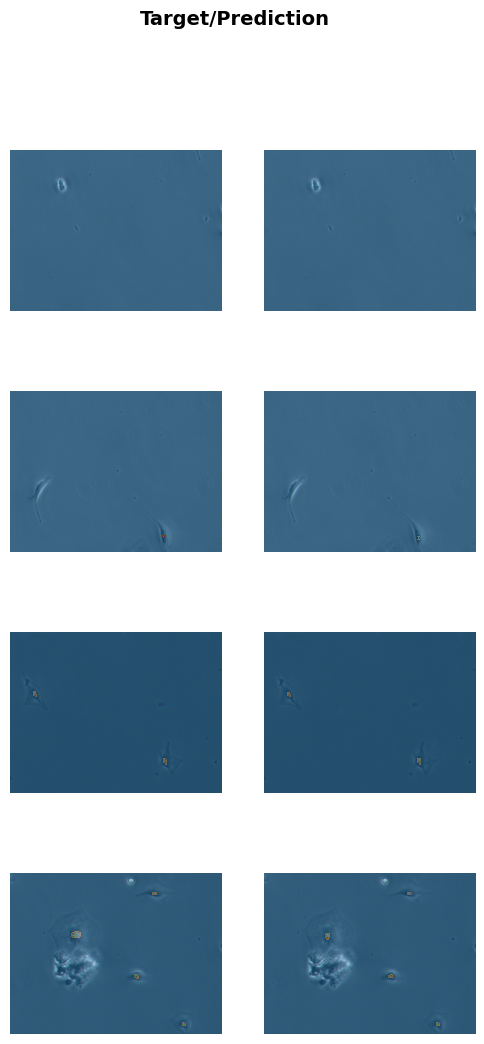

In [ ]:
# loadedlearner.show_results(max_n=17,ds_idx=1)
loadedlearner.dls[0].show_results(b,preds)

In [ ]:
os.path.isdir("temp/models/matt")

True

In [ ]:
opt = loadedlearner.opt
loadedlearner.opt = None
loadedlearner.export(fname=local_modelsfolder/outmodelname);
loadedlearner.opt = opt
push_modelsfolder();

local/models->temp/models/fastai
temp/models/fastai gs:/optotaxisbucket/models/fastai


# Segment Experiment - Google Drive
Will process each folder and subfolder individually. Works great with large numbers of images split into subfolders (like stage positions) and with small numbers of images in the main folder. Pulls data from google drive.

### Loading a trained model

In [22]:
print("available cpu count:",len(os.sched_getaffinity(0)));

available cpu count: 2


In [23]:
fetch_modelsfolder();
def label_func(x): return None; ##dummy functions to make unpickling work, never used
def mask_from_image(x): return None

loadedlearner=load_learner(local_modelsfolder/segment_model_name);
if torch.cuda.is_available():
  print("using gpu");
  loadedlearner.model = loadedlearner.model.cuda();


### Prepare Images for segmentation

In [24]:
comp_fns = [];

if do_splitting:
  comp_fns.append(create_split_image_process_fn(x_slices,y_slices,context_bounds,crop));

if do_scaling:
  comp_fns.append(create_scale_image_process_fn(scale_factor))

im_comp_fns = [prepare_image,*comp_fns];

if image_stacking:
    im_comp_fns.insert(0,create_stack_adjacents())

im_proc_fn = compose_proc_functions(im_comp_fns)
process_segmentation_images(im_proc_fn);

100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


In [142]:
## prepare input file reading
subfolders = [ Path(f.path) if f.is_dir() else None for f in os.scandir(segmentation_images_folder)  ]
toplevel_images = False;
if None in subfolders:
  subfolders = [s for s in subfolders if s is not None];
  toplevel_images = True;
corresponding_outs = [segmentation_output_folder];
if len(subfolders) == 0:
  subfolders = [segmentation_images_folder];
  toplevel_images = True;
else:
  corresponding_outs = [segmentation_output_folder/f.name for f in subfolders];
  if toplevel_images:
    subfolders.append(segmentation_images_folder);
    corresponding_outs.append(segmentation_output_folder);
  for c in corresponding_outs:
    if not(os.path.exists(c)):
      os.mkdir(c);

batchSize = 32;

folderChunks = [];
sub_lengths = [];
for f,out in zip(subfolders,corresponding_outs):
  print("pulling files from",os.path.basename(f))
  files = get_image_files(f);
  completed_masks = os.listdir(out);
  print("input files:",len(files))
  print("output files:",len(completed_masks))
  files = [fi for fi in files if os.path.basename(fi) not in completed_masks];
  print("remaining files:",len(files))
  sub_lengths.append(len(files));

  folderChunks.append(chunked(files, chunk_sz=batchSize));


pulling files from segmentation_images
input files: 1125
output files: 0
remaining files: 1125


### Segment images

In [143]:
with torch.no_grad():
  for fileChunks,outFolder,num,f in zip(folderChunks,corresponding_outs,sub_lengths,subfolders):
    print("in:",os.path.basename(f),"out:",os.path.basename(outFolder),"count:",num);
    for chunk in progress_bar(fileChunks,num//batchSize+1):
      dl = loadedlearner.dls.test_dl(chunk,num_workers=len(os.sched_getaffinity(0)));
      if torch.cuda.is_available():
        dl = loadedlearner.dls.test_dl(chunk,num_workers=len(os.sched_getaffinity(0)),device='cuda');
        dl.to('cuda');
      print(chunk)
      inp,r,_,dec_preds = loadedlearner.get_preds(with_input=True,with_decoded=True,dl=dl);
      for path,raw,prediction in zip(chunk,r,dec_preds):
        basename = os.path.basename(path);
        if basename == "migration45_s7_t338.TIF-0.TIF":
            raise Exception()
        # im = raw.numpy()
        im = torch.sigmoid(raw[1]/raw[0]).numpy()
        # print(im.dtype)
        # print(np.unique(im))
        # im = im.astype('uint8');
        # print(im.min(),im.max());
        imsave(outFolder/basename,im,check_contrast=False);
    with open(outFolder/'segmentation_complete.flag','w') as f:
      pass;
    print("folder processing complete");

in: segmentation_images out: segmentation_masks_out count: 1125


[Path('local/segmentation_images/migration53_s2_t181.TIF-15.TIF'), Path('local/segmentation_images/migration51_s4_t251.TIF-22.TIF'), Path('local/segmentation_images/migration46_s3_t316.TIF-4.TIF'), Path('local/segmentation_images/migration46_s3_t316.TIF-19.TIF'), Path('local/segmentation_images/migration45_s7_t338.TIF-18.TIF'), Path('local/segmentation_images/migration47_s3_t16.TIF-8.TIF'), Path('local/segmentation_images/migration55_s12_t136.TIF-16.TIF'), Path('local/segmentation_images/migration51_s5_t370.TIF-6.TIF'), Path('local/segmentation_images/migration46_s3_t316.TIF-9.TIF'), Path('local/segmentation_images/migration45_s11_t15.TIF-11.TIF'), Path('local/segmentation_images/migration47_s3_t16.TIF-5.TIF'), Path('local/segmentation_images/migration46_s6_t248.TIF-0.TIF'), Path('local/segmentation_images/migration50_s9_t147.TIF-4.TIF'), Path('local/segmentation_images/migration51_s3_t129.TIF-18.TIF'), Path('local/segmentation_images/migration56_s2_t6.TIF-7.TIF'), Path('local/segmenta

[Path('local/segmentation_images/migration55_s6_t99.TIF-22.TIF'), Path('local/segmentation_images/migration56_s2_t6.TIF-3.TIF'), Path('local/segmentation_images/migration51_s10_t356.TIF-18.TIF'), Path('local/segmentation_images/migration45_s7_t443.TIF-15.TIF'), Path('local/segmentation_images/migration54_s9_t149.TIF-3.TIF'), Path('local/segmentation_images/migration56_s5_t187.TIF-5.TIF'), Path('local/segmentation_images/migration51_s3_t129.TIF-19.TIF'), Path('local/segmentation_images/migration54_s6_t20.TIF-22.TIF'), Path('local/segmentation_images/migration55_s12_t136.TIF-1.TIF'), Path('local/segmentation_images/migration50_s11_t4.TIF-15.TIF'), Path('local/segmentation_images/migration47_s3_t16.TIF-0.TIF'), Path('local/segmentation_images/migration55_s5_t225.TIF-3.TIF'), Path('local/segmentation_images/migration50_s11_t4.TIF-6.TIF'), Path('local/segmentation_images/migration54_s10_t255.TIF-21.TIF'), Path('local/segmentation_images/migration56_s4_t53.TIF-5.TIF'), Path('local/segmentati

[Path('local/segmentation_images/migration47_s2_t217.TIF-10.TIF'), Path('local/segmentation_images/migration50_s9_t148.TIF-19.TIF'), Path('local/segmentation_images/migration45_s3_t119.TIF-13.TIF'), Path('local/segmentation_images/migration55_s6_t99.TIF-5.TIF'), Path('local/segmentation_images/migration50_s9_t147.TIF-6.TIF'), Path('local/segmentation_images/migration50_s11_t51.TIF-5.TIF'), Path('local/segmentation_images/migration55_s5_t225.TIF-1.TIF'), Path('local/segmentation_images/migration55_s12_t136.TIF-24f.TIF'), Path('local/segmentation_images/migration47_s6_t78.TIF-3.TIF'), Path('local/segmentation_images/migration53_s3_t30.TIF-19.TIF'), Path('local/segmentation_images/migration51_s4_t251.TIF-9.TIF'), Path('local/segmentation_images/migration55_s6_t99.TIF-16.TIF'), Path('local/segmentation_images/migration51_s5_t370.TIF-2.TIF'), Path('local/segmentation_images/migration54_s6_t20.TIF-13.TIF'), Path('local/segmentation_images/migration45_s4_t43.TIF-18.TIF'), Path('local/segmenta

[Path('local/segmentation_images/migration50_s11_t4.TIF-8.TIF'), Path('local/segmentation_images/migration54_s7_t162.TIF-19.TIF'), Path('local/segmentation_images/migration53_s3_t30.TIF-12.TIF'), Path('local/segmentation_images/migration46_s1_t338.TIF-15.TIF'), Path('local/segmentation_images/migration47_s7_t141.TIF-11.TIF'), Path('local/segmentation_images/migration45_s11_t15.TIF-14.TIF'), Path('local/segmentation_images/migration56_s4_t53.TIF-6.TIF'), Path('local/segmentation_images/migration51_s3_t129.TIF-9.TIF'), Path('local/segmentation_images/migration56_s7_t43.TIF-18.TIF'), Path('local/segmentation_images/migration47_s3_t16.TIF-13.TIF'), Path('local/segmentation_images/migration46_s3_t316.TIF-20.TIF'), Path('local/segmentation_images/migration54_s6_t20.TIF-14.TIF'), Path('local/segmentation_images/migration47_s3_t16.TIF-7.TIF'), Path('local/segmentation_images/migration46_s6_t434.TIF-16.TIF'), Path('local/segmentation_images/migration45_s4_t43.TIF-12.TIF'), Path('local/segmentat

[Path('local/segmentation_images/migration54_s7_t87.TIF-0.TIF'), Path('local/segmentation_images/migration47_s7_t141.TIF-19.TIF'), Path('local/segmentation_images/migration50_s9_t148.TIF-0.TIF'), Path('local/segmentation_images/migration47_s6_t78.TIF-12.TIF'), Path('local/segmentation_images/migration46_s6_t434.TIF-17.TIF'), Path('local/segmentation_images/migration54_s7_t87.TIF-16.TIF'), Path('local/segmentation_images/migration47_s7_t141.TIF-14.TIF'), Path('local/segmentation_images/migration47_s2_t134.TIF-15.TIF'), Path('local/segmentation_images/migration55_s5_t40.TIF-0.TIF'), Path('local/segmentation_images/migration56_s7_t43.TIF-20.TIF'), Path('local/segmentation_images/migration55_s5_t40.TIF-1.TIF'), Path('local/segmentation_images/migration55_s12_t136.TIF-17.TIF'), Path('local/segmentation_images/migration47_s3_t16.TIF-6.TIF'), Path('local/segmentation_images/migration56_s4_t53.TIF-24f.TIF'), Path('local/segmentation_images/migration47_s7_t141.TIF-20.TIF'), Path('local/segmenta

[Path('local/segmentation_images/migration47_s7_t141.TIF-21.TIF'), Path('local/segmentation_images/migration50_s11_t51.TIF-9.TIF'), Path('local/segmentation_images/migration56_s7_t43.TIF-23.TIF'), Path('local/segmentation_images/migration53_s2_t86.TIF-9.TIF'), Path('local/segmentation_images/migration45_s4_t43.TIF-24f.TIF'), Path('local/segmentation_images/migration51_s10_t356.TIF-14.TIF'), Path('local/segmentation_images/migration53_s7_t60.TIF-2.TIF'), Path('local/segmentation_images/migration55_s12_t136.TIF-13.TIF'), Path('local/segmentation_images/migration56_s5_t187.TIF-18.TIF'), Path('local/segmentation_images/migration47_s6_t78.TIF-14.TIF'), Path('local/segmentation_images/migration47_s2_t217.TIF-7.TIF'), Path('local/segmentation_images/migration47_s2_t217.TIF-16.TIF'), Path('local/segmentation_images/migration53_s2_t86.TIF-17.TIF'), Path('local/segmentation_images/migration50_s9_t148.TIF-8.TIF'), Path('local/segmentation_images/migration56_s2_t6.TIF-4.TIF'), Path('local/segmenta

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:14                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Exception

In [145]:
print(basename)
[p.name for p in chunk].index(basename)

migration45_s7_t338.TIF-0.TIF


31

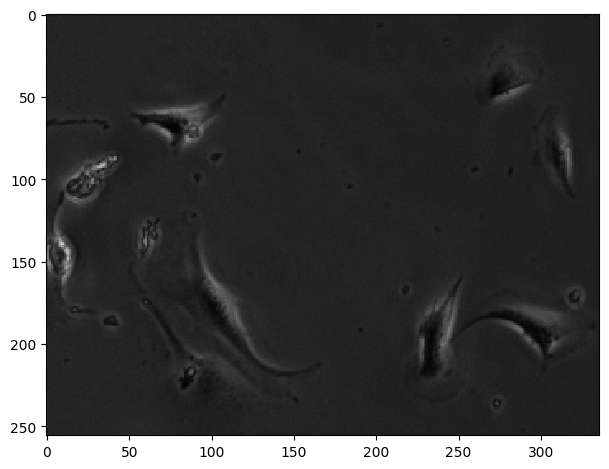

In [146]:
imshow(inp[1,0].numpy())

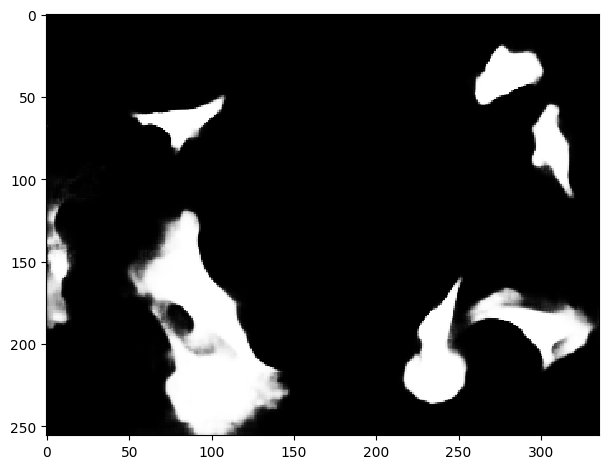

In [147]:
imshow(r[1,1].numpy())

TensorImage(0.9999) TensorImage(1.1541)
torch.Size([336])
TensorImage(0.7310) TensorImage(0.7603)


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/skimage/io/_io.py:166 in imshow                          │
│                                                                                                  │
│   163 │   """                                                                                    │
│   164 │   if isinstance(arr, str):                                                               │
│   165 │   │   arr = call_plugin('imread', arr, plugin=plugin)                                    │
│ ❱ 166 │   return call_plugin('imshow', arr, plugin=plugin, **plugin_args)                        │
│   167                                                                                            │
│   168                                                                                            │
│   169 def imshow_collection(ic, plugin=None, **plugin_args):                                     │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/skimage/io/manage_plugins.py:207 in call_plugin          │
│                                                                                                  │
│   204 │   │   │   raise RuntimeError('Could not find the plugin "%s" for %s.' %                  │
│   205 │   │   │   │   │   │   │      (plugin, kind))                                             │
│   206 │                                                                                          │
│ ❱ 207 │   return func(*args, **kwargs)                                                           │
│   208                                                                                            │
│   209                                                                                            │
│   210 def use_plugin(name, kind=None):                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158 in imshow   │
│                                                                                                  │
│   155 │   kwargs.setdefault('vmax', hi)                                                          │
│   156 │                                                                                          │
│   157 │   ax = ax or plt.gca()                                                                   │
│ ❱ 158 │   ax_im = ax.imshow(image, **kwargs)                                                     │
│   159 │   if (cmap != _default_colormap and show_cbar is not False) or show_cbar:                │
│   160 │   │   divider = make_axes_locatable(ax)                                                  │
│   161 │   │   cax = divider.append_axes("right", size="5%", pad=0.05)                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/matplotlib/__init__.py:1442 in inner                     │
│                                                                                                  │
│   1439 │   @functools.wraps(func)                                                                │
│   1440 │   def inner(ax, *args, data=None, **kwargs):                                            │
│   1441 │   │   if data is None:                                                                  │
│ ❱ 1442 │   │   │   return func(ax, *map(sanitize_sequence, args), **kwargs)                      │
│   1443 │   │                                               

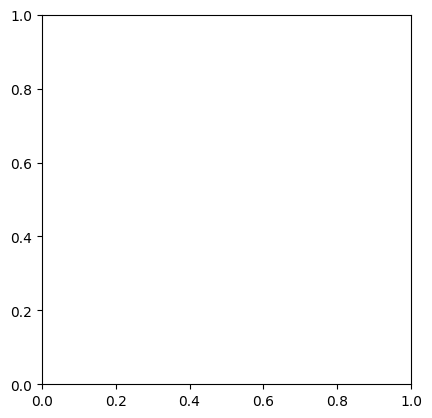

In [148]:
q = raw[0,0]/raw[0,1]
print(q.min(),q.max())
s = torch.sigmoid(raw[0,0]/raw[0,1])
print(s.shape)
print(s.min(),s.max())
imshow(s.numpy())


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


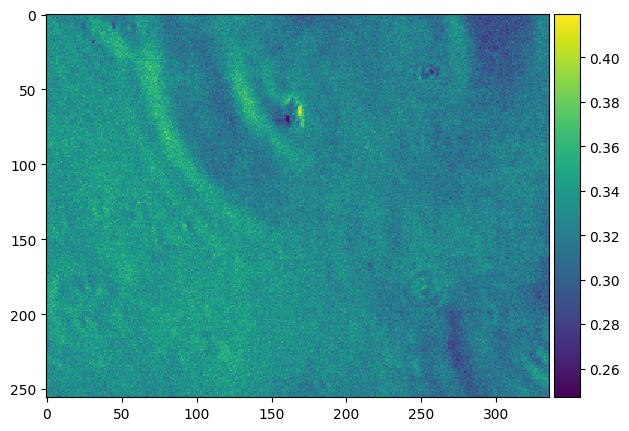

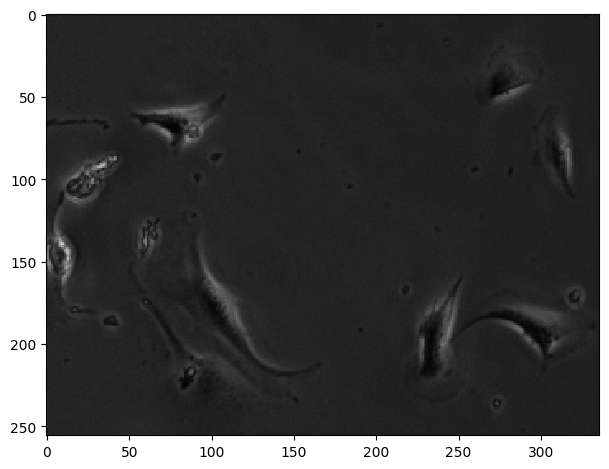

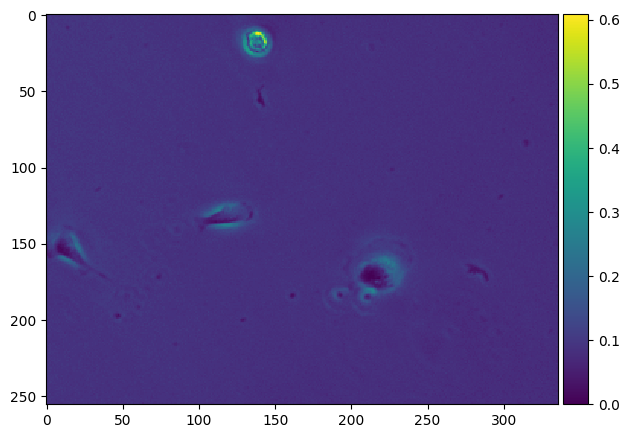

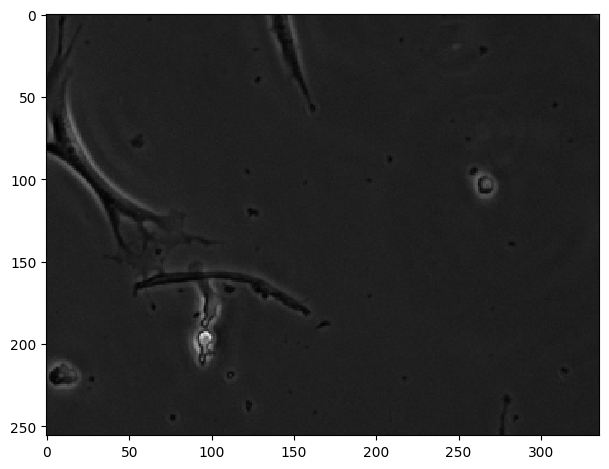

<Figure size 640x480 with 0 Axes>

In [151]:
import builtins
builtins.dir(dl)
t = list(itertools.islice(dl,1))[-1]
rout = loadedlearner.model(t[0])
for i in range(4):
    imshow(t[0][i][0].numpy())
    plt.figure()

In [ ]:
from fastai.torch_basics import first

In [ ]:
a,b,preds = loadedlearner.get_preds(dl=[t], with_decoded=True)

In [161]:
p = Path("gdrive/Othercomputers/UNC Laptop/iter3/")

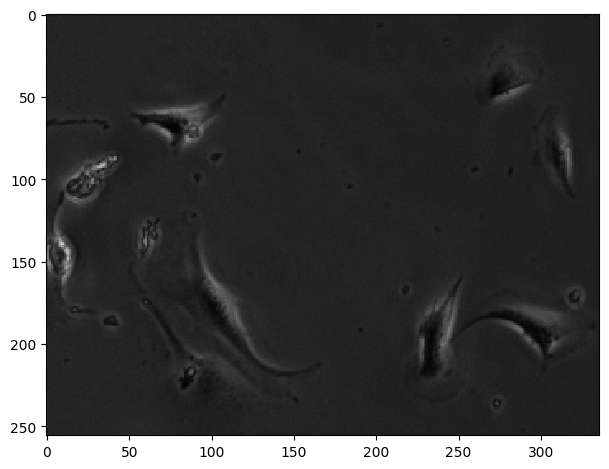

In [162]:
imshow(t[0][1][0].numpy())
imsave(p/"example_img.TIF",t[0][1][0].numpy())

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
<ipython-input-163-2a1a228c48d3>:2: UserWarning: /content/gdrive/Othercomputers/UNC Laptop/iter3/example_fastai_preds.TIF is a low contrast image
  imsave(p/"example_fastai_preds.TIF",dec_preds[1].numpy())


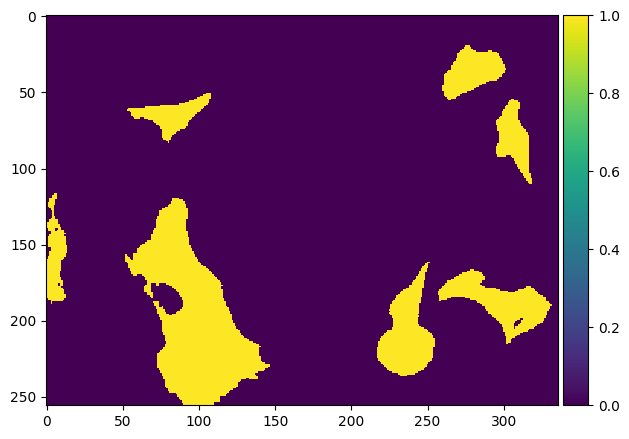

In [163]:
imshow(dec_preds[1].numpy())
imsave(p/"example_fastai_preds.TIF",dec_preds[1].numpy())

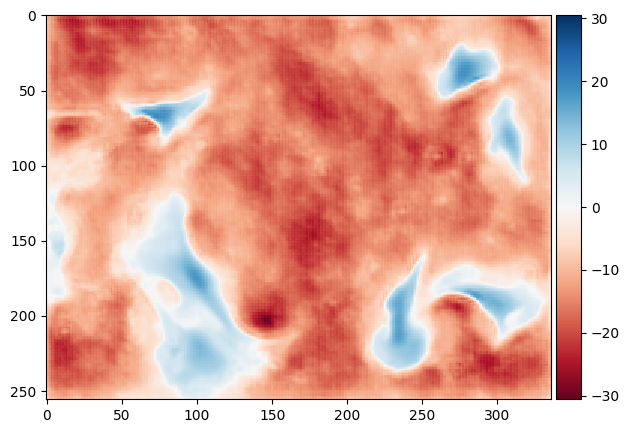

In [164]:
imshow(((rout[1][1]-rout[1][0]).detach().numpy()))
imsave(p/"example_raw_difference.TIF",((rout[1][1]-rout[1][0]).detach().numpy()))

### Deprocess and Export Masks

In [ ]:
comp_fns = [];

if segmentation_mask_scale_factor != 1:
  comp_fns.append(create_scale_image_process_fn(segmentation_mask_scale_factor))

if do_splitting:
  comp_fns.append(create_stitch_image_process_fn(x_slices,y_slices,context_bounds,crop));

mask_deproc_fn = compose_proc_functions(comp_fns)

deprocess_segmentation_masks(mask_deproc_fn);

checking prospective source /content/gdrive/Othercomputers/UNC Laptop/iter3/round7/seg_out
not file nor gcp: writing directly to source


  4%|▍         | 12/301 [00:00<00:02, 115.93it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


  8%|▊         | 25/301 [00:00<00:02, 122.38it/s]

deprocessed: []
deprocessed: []
deprocessed: []


 13%|█▎        | 38/301 [00:00<00:02, 124.91it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 17%|█▋        | 52/301 [00:00<00:01, 127.31it/s]

deprocessed: []
deprocessed: []
deprocessed: []


 22%|██▏       | 65/301 [00:00<00:01, 126.34it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 26%|██▌       | 78/301 [00:00<00:01, 126.01it/s]

deprocessed: []
deprocessed: []
deprocessed: []


 30%|███       | 91/301 [00:00<00:01, 125.92it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 35%|███▍      | 104/301 [00:00<00:01, 123.47it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []

 39%|███▉      | 118/301 [00:00<00:01, 125.75it/s]


deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 49%|████▊     | 146/301 [00:01<00:01, 131.95it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 53%|█████▎    | 160/301 [00:01<00:01, 133.24it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 58%|█████▊    | 174/301 [00:01<00:00, 134.41it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 62%|██████▏   | 188/301 [00:01<00:00, 135.34it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 67%|██████▋   | 202/301 [00:01<00:00, 135.65it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


<ipython-input-13-08c8cd2a73aa>:182: UserWarning: non-image file in segmentation_masks dir: segmentation_complete.flag
  warn(f"non-image file in {keyword} dir: {im}");
 72%|███████▏  | 217/301 [00:01<00:00, 137.91it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 77%|███████▋  | 231/301 [00:01<00:00, 137.66it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []


 86%|████████▌ | 259/301 [00:01<00:00, 132.22it/s]

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
stitched image: Image  of shape (1024, 1344) and metadata ['sourcefolder', 'keyword', 'history', 'adjacency_names']
deprocessed: [Img(name='migration53_s6_t4.TIF', img=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), metadata=OrderedDict([('sourcefolder', Path('/content/gdrive/Othercomputers/UNC Laptop/iter3/round7/seg_out')), ('keyword', 'segmentation_masks'), ('history', []), ('adjacency_names', ['migration53_s6_t3.TIF', 'migration53_s6_t5.TIF'])]))]


 91%|█████████ | 273/301 [00:02<00:00, 73.11it/s] 

deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
deprocessed: []
stitched image: Image  of shape (1024, 1344) and metadata ['sourcefolder', 'keyword', 'history', 'adjacency_names']
deprocessed: [Img(name='migration50_s3_t195.TIF', img=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), metadata=OrderedDict([('sourcefolder', Path('/content/gdrive/Othercomputers/UNC Laptop/iter3/round7/seg_out')), ('keyword', 'segmentation_masks'), ('history', []), ('adjacency_names', ['migration50_s3_t194.TIF', 'migration50_s3_t196.TIF'])]))]


 95%|█████████▌| 286/301 [00:02<00:00, 52.88it/s]

deprocessed: []
stitched image: Image  of shape (1024, 1344) and metadata ['sourcefolder', 'keyword', 'history', 'adjacency_names']
deprocessed: [Img(name='migration50_s2_t129.TIF', img=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), metadata=OrderedDict([('sourcefolder', Path('/content/gdrive/Othercomputers/UNC Laptop/iter3/round7/seg_out')), ('keyword', 'segmentation_masks'), ('history', []), ('adjacency_names', ['migration50_s2_t128.TIF', 'migration50_s2_t130.TIF'])]))]
stitched image: Image  of shape (1024, 1344) and metadata ['sourcefolder', 'keyword', 'history', 'adjacency_names']
deprocessed: [Img(name='migration50_s5_t5.TIF', img=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 

 98%|█████████▊| 295/301 [00:04<00:00, 16.37it/s]

stitched image: Image  of shape (1024, 1344) and metadata ['sourcefolder', 'keyword', 'history', 'adjacency_names']
deprocessed: [Img(name='migration55_s12_t163.TIF', img=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), metadata=OrderedDict([('sourcefolder', Path('/content/gdrive/Othercomputers/UNC Laptop/iter3/round7/seg_out')), ('keyword', 'segmentation_masks'), ('history', []), ('adjacency_names', ['migration55_s12_t162.TIF', 'migration55_s12_t164.TIF'])]))]
deprocessed: []
stitched image: Image  of shape (1024, 1344) and metadata ['sourcefolder', 'keyword', 'history', 'adjacency_names']
deprocessed: [Img(name='migration51_s4_t55.TIF', img=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       

100%|██████████| 301/301 [00:05<00:00, 52.40it/s]
